In [1]:
from google.colab import drive
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve

import spacy

In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 50.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Positive Examples (Keep only entries where the Rating column is not null)

normalized_jester_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Preprocessed-Datasets/Positive-Examples/jester/normalized_jester.csv')
normalized_reddit_jokes_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Preprocessed-Datasets/Positive-Examples/joke-dataset/normalized_reddit_jokes.csv')
normalized_stupidstuff_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Preprocessed-Datasets/Positive-Examples/joke-dataset/normalized_stupidstuff.csv')

normalized_jester_df = normalized_jester_df[normalized_jester_df['Rating'].notna()]
normalized_reddit_jokes_df = normalized_reddit_jokes_df[normalized_reddit_jokes_df['Rating'].notna()]
normalized_stupidstuff_df = normalized_stupidstuff_df[normalized_stupidstuff_df['Rating'].notna()]

# Negative Examples (All of them, put 0 in the Rating column)

news_category_dataset_df = pd.read_csv('/content/drive/MyDrive/Proiect NLP/Preprocessed-Datasets/Negative-Examples/News_Category_Dataset_v3/News_Category_Dataset_v3.csv')
news_category_dataset_df['Rating'] = news_category_dataset_df['Rating'].fillna(0.0)

combined_df = pd.concat([normalized_jester_df, normalized_reddit_jokes_df, normalized_stupidstuff_df, news_category_dataset_df], ignore_index=True)

In [5]:
combined_df.head()

,ID,Title,Category,Body,Rating
0,5,NaN,NaN,Q.\tWhat's O. J. Simpson's Internet address? \...,0.153659
1,7,NaN,NaN,How many feminists does it take to screw in a ...,0.145475
2,8,NaN,NaN,Q. Did you hear about the dyslexic devil worsh...,0.321407
3,13,NaN,NaN,They asked the Japanese visitor if they have e...,0.334060
4,15,NaN,NaN,Q: What did the blind person say when given s...,0.212328


In [6]:
def preprocessed_sample(sample):
  sample = str(sample)
  sample = re.sub(r'[^a-zA-Z0-9\s]', '', sample) # Only letters (lowercase and uppercase) + digits
  sample = sample.lower() # Everything lowercase
  sample = re.sub(r'\d+', 'NUMBER', sample) # Replace all numerical values with a common label.
  return sample

combined_df['Body'] = combined_df['Body'].apply(preprocessed_sample)

In [7]:
combined_df.head()

,ID,Title,Category,Body,Rating
0,5,NaN,NaN,q\twhats o j simpsons internet address \r\na\t...,0.153659
1,7,NaN,NaN,how many feminists does it take to screw in a ...,0.145475
2,8,NaN,NaN,q did you hear about the dyslexic devil worshi...,0.321407
3,13,NaN,NaN,they asked the japanese visitor if they have e...,0.334060
4,15,NaN,NaN,q what did the blind person say when given so...,0.212328


In [8]:
TEST_PERCENTAGE_FROM_ALL = 0.2
VAL_PERCENTAGE_FROM_TRAIN = 0.2

# Ensure there are jokes and non-jokes in each dataset.

X_train_zero = combined_df[combined_df['Rating'] == 0.0]['Body']
y_train_zero = combined_df[combined_df['Rating'] == 0.0]['Rating']

X_train_notzero = combined_df[combined_df['Rating'] != 0.0]['Body']
y_train_notzero = combined_df[combined_df['Rating'] != 0.0]['Rating']

X_train_zero, X_test_zero, y_train_zero, y_test_zero = train_test_split(X_train_zero, y_train_zero, test_size=TEST_PERCENTAGE_FROM_ALL, random_state=17)
X_train_zero, X_val_zero, y_train_zero, y_val_zero = train_test_split(X_train_zero, y_train_zero, test_size=VAL_PERCENTAGE_FROM_TRAIN, random_state=17)

X_train_notzero, X_test_notzero, y_train_notzero, y_test_notzero = train_test_split(X_train_notzero, y_train_notzero, test_size=TEST_PERCENTAGE_FROM_ALL, random_state=17)
X_train_notzero, X_val_notzero, y_train_notzero, y_val_notzero = train_test_split(X_train_notzero, y_train_notzero, test_size=VAL_PERCENTAGE_FROM_TRAIN, random_state=17)

# Form Datasets

X_train = pd.concat([X_train_zero, X_train_notzero])
y_train = pd.concat([y_train_zero, y_train_notzero])

X_val = pd.concat([X_val_zero, X_val_notzero])
y_val = pd.concat([y_val_zero, y_val_notzero])

X_test = pd.concat([X_test_zero, X_test_notzero])
y_test = pd.concat([y_test_zero, y_test_notzero])

print('Train zero:', X_train_zero.shape[0], 'Train not zero:', X_train_notzero.shape[0])
print('Val zero:', X_val_zero.shape[0], 'Val not zero:', X_val_notzero.shape[0])
print('Test zero:', X_test_zero.shape[0], 'Test not zero:', X_test_notzero.shape[0])

Train zero: 173513 Train not zero: 87601
Val zero: 43379 Val not zero: 21901
Test zero: 54223 Test not zero: 27376


Count / Tfidf Vectorizer + Neural Network Method

In [9]:
# vectorizer = CountVectorizer(max_features=1024)
vectorizer = TfidfVectorizer(max_features=4096)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [10]:
class FeaturesDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.toarray(), dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)
    self.length = self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return self.length


class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(NeuralNetwork, self).__init__()

    if (hidden_sizes is None) or len(hidden_sizes) == 0:
      raise ValueError('hidden_sizes is None or empty')

    self.layers = nn.Sequential()
    self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
    for idx in range(1, len(hidden_sizes)):
      self.layers.append(nn.ReLU())
      self.layers.append(nn.Linear(hidden_sizes[idx - 1], hidden_sizes[idx]))

    self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
    # self.layers.append(nn.Sigmoid())

  def forward(self, X):
    return self.layers(X)

In [11]:
BATCH_SIZE = 64

train_dataset = FeaturesDataset(X_train_vec, y_train)
val_dataset = FeaturesDataset(X_val_vec, y_val)
test_dataset = FeaturesDataset(X_test_vec, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNetwork(input_size=X_train_vec.shape[1], hidden_sizes=[512, 512, 512], output_size=1)
model.to(device)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [13]:
def train(model, loss_function, epochs, learning_rate, train_dataloader, val_dataloader):
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

  train_epoch_losses = []
  val_epoch_losses = []

  for epoch in range(epochs):
    # Train

    model.train()
    train_current_epoch_loss = 0.0

    for batch_idx, (X_batch, y_batch) in enumerate(train_dataloader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = loss_function(outputs.view(-1), y_batch)

      loss.backward()
      optimizer.step()

      train_current_epoch_loss += loss.item()

    scheduler.step()

    train_current_epoch_avg_loss = train_current_epoch_loss / len(train_dataloader)
    train_epoch_losses.append(train_current_epoch_avg_loss)

    print(f'Training, Epoch {epoch + 1}/{epochs}, Loss: {train_current_epoch_avg_loss}')

    # Validation

    model.eval()
    val_current_epoch_loss = 0.0

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in enumerate(val_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = loss_function(outputs.view(-1), y_batch)

        val_current_epoch_loss += loss.item()

      val_current_epoch_avg_loss = val_current_epoch_loss / len(val_dataloader)
      val_epoch_losses.append(val_current_epoch_avg_loss)

      print(f'Validation, Epoch {epoch + 1}/{epochs}, Loss: {val_current_epoch_avg_loss}')

  return train_epoch_losses, val_epoch_losses


def plot_train_results(train_epoch_losses, val_epoch_losses):

  plt.figure(figsize=(12, 6))
  plt.plot(train_epoch_losses, label='Training Loss', color='blue')
  plt.plot(val_epoch_losses, label='Validation Loss', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses')
  plt.legend()
  plt.show()

Training, Epoch 1/10, Loss: 0.004736205097420249
Validation, Epoch 1/10, Loss: 0.00437780590072465
Training, Epoch 2/10, Loss: 0.004275631838190324
Validation, Epoch 2/10, Loss: 0.0044040125877686746
Training, Epoch 3/10, Loss: 0.0033122691853004742
Validation, Epoch 3/10, Loss: 0.004549610644909419
Training, Epoch 4/10, Loss: 0.0023978393830708343
Validation, Epoch 4/10, Loss: 0.0045422906023634595
Training, Epoch 5/10, Loss: 0.0019678597626307014
Validation, Epoch 5/10, Loss: 0.004913684745795264
Training, Epoch 6/10, Loss: 0.0016117283113589128
Validation, Epoch 6/10, Loss: 0.004551235914371934
Training, Epoch 7/10, Loss: 0.0013412142768309124
Validation, Epoch 7/10, Loss: 0.004616936373691697
Training, Epoch 8/10, Loss: 0.0011724174727538248
Validation, Epoch 8/10, Loss: 0.0045989416173811415
Training, Epoch 9/10, Loss: 0.0010593043820640716
Validation, Epoch 9/10, Loss: 0.00457529142850949
Training, Epoch 10/10, Loss: 0.001000171345533634
Validation, Epoch 10/10, Loss: 0.004555753

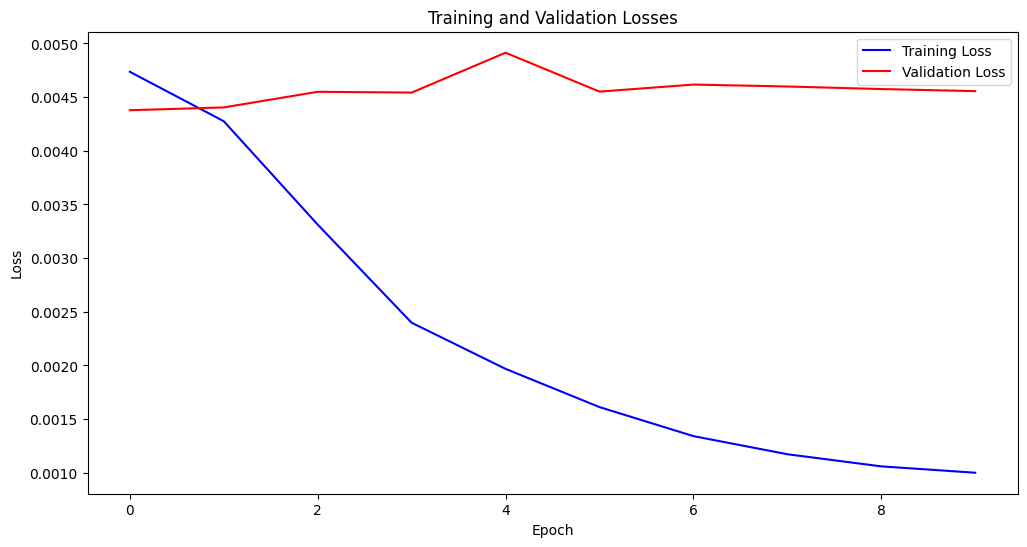

In [14]:
train_epoch_losses, val_epoch_losses = train(model, nn.MSELoss(), 10, 0.001, train_dataloader, val_dataloader)

plot_train_results(train_epoch_losses, val_epoch_losses)

In [15]:
def evaluate_model(model, dataloader, sigmoid_threshold):
  model.eval()

  predictions = []
  labels = []
  scores = []

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(X_batch)
      sigmoid_outputs = torch.sigmoid(outputs)
      current_predictions = (sigmoid_outputs > sigmoid_threshold)

      predictions.extend(current_predictions.cpu().numpy())
      labels.extend((y_batch > 0.0).cpu().numpy()) # 0.0 rated texts are not jokes, positive rated texts are jokes.
      scores.extend(sigmoid_outputs.cpu().numpy())

  return predictions, labels, scores


def find_best_sigmoid_threshold(model, val_dataloader):
  best_f1_score = 0.0
  best_sigmoid_threshold = 0.5

  sigmoid_thresholds = []
  precisions = []
  recalls = []
  f1_scores = []

  for sigmoid_threshold in np.arange(0.0, 1.0, 0.05):
    val_predictions, val_labels, val_scores = evaluate_model(model, val_dataloader, sigmoid_threshold)

    precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary', zero_division=0)

    if f1_score > best_f1_score:
      best_f1_score = f1_score
      best_sigmoid_threshold = sigmoid_threshold

    sigmoid_thresholds.append(sigmoid_threshold)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    print('Sigmoid Threshold:', sigmoid_threshold, 'Precision:', precision, 'Recall:', recall, 'F1 Score:', f1_score)

  plt.figure(figsize=(12, 6))
  plt.plot(sigmoid_thresholds, f1_scores, marker='o', linestyle='-', color='blue')
  plt.xlabel('Sigmoid Threshold')
  plt.ylabel('F1 Score')
  plt.title('F1 Score Evolution')
  plt.show()

  return best_sigmoid_threshold


def plot_best_sigmoid_threshold_results(predictions, labels, scores):
  conf_matrix = confusion_matrix(labels, predictions)

  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Joke', 'Joke'], yticklabels=['Not Joke', 'Joke'])

  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')

  plt.show()

  if len(np.unique(labels)) == 2:
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average='binary', zero_division=0)
  else:
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)

  print('Precision:', precision)
  print('Recall:', recall)
  print('F1 Score:', f1_score)

  precisions, recalls, thresholds = precision_recall_curve(labels, scores)

  plt.figure()
  plt.plot(recalls, precisions)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  # plt.grid(True)
  plt.show()

  return precision, recall, f1_score

Sigmoid Threshold: 0.0 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.05 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.1 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.15000000000000002 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.2 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.25 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.30000000000000004 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.35000000000000003 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.4 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid Threshold: 0.45 Precision: 0.3354932598039216 Recall: 1.0 F1 Score: 0.5024259873137495
Sigmoid T

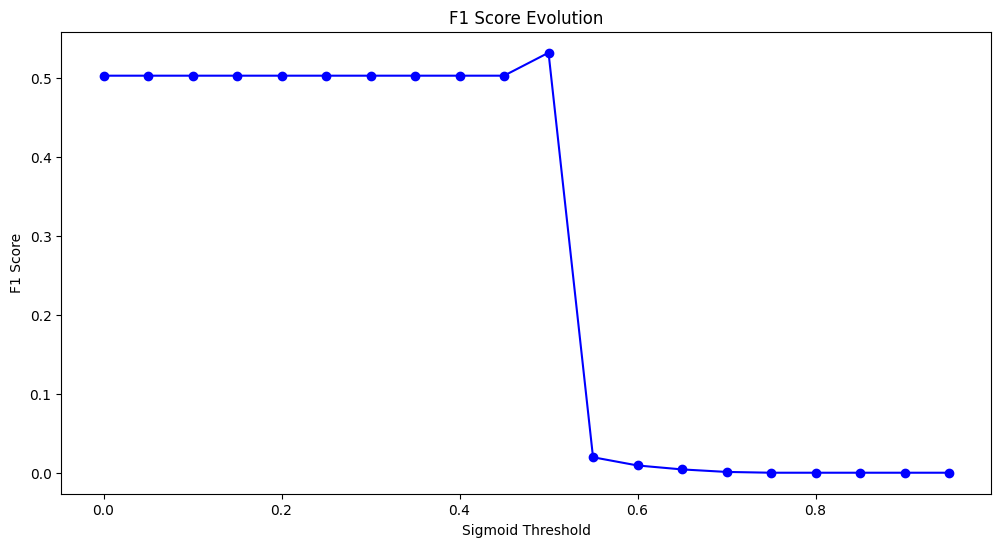

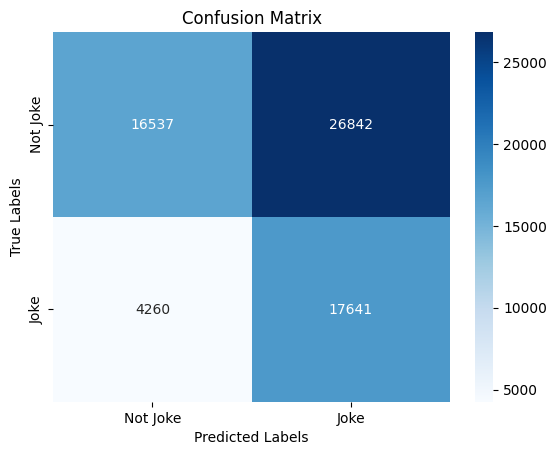

Precision: 0.39657846817885484
Recall: 0.8054883338660335
F1 Score: 0.5314834899975898


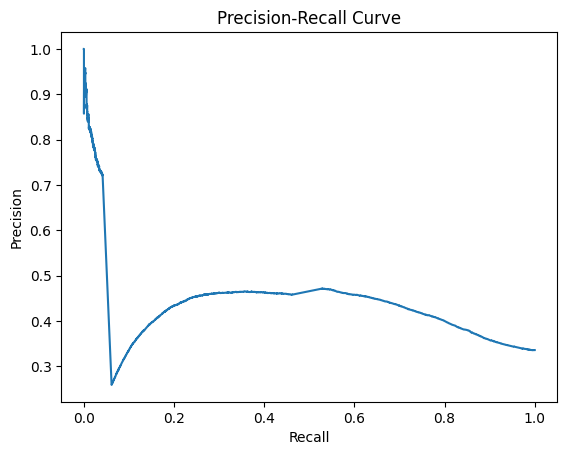

In [16]:
best_sigmoid_threshold = find_best_sigmoid_threshold(model, val_dataloader)

val_predictions, val_labels, val_scores = evaluate_model(model, val_dataloader, best_sigmoid_threshold)

precision, recall, f1_score = plot_best_sigmoid_threshold_results(val_predictions, val_labels, val_scores)

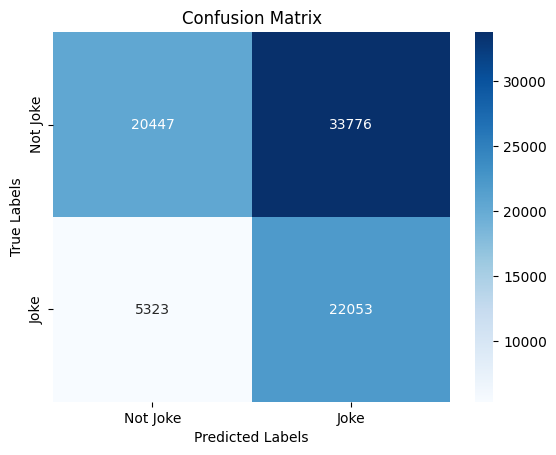

Precision: 0.39500976195167387
Recall: 0.8055596142606662
F1 Score: 0.5300883360374977


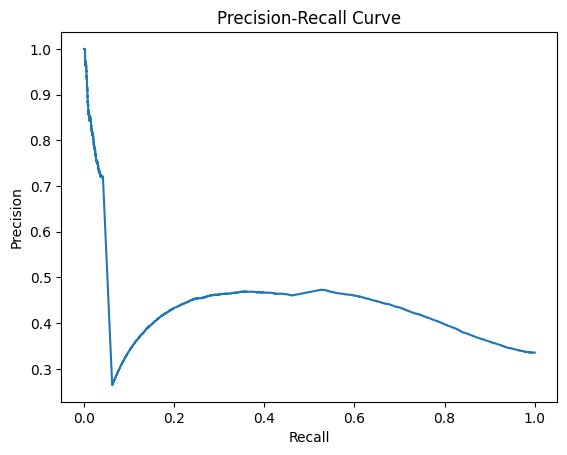

In [17]:
test_predictions, test_labels, test_scores = evaluate_model(model, test_dataloader, best_sigmoid_threshold)

precision, recall, f1_score = plot_best_sigmoid_threshold_results(test_predictions, test_labels, test_scores)

Positional Encoding + Neural Network Method

In [18]:
nlp = spacy.load('en_core_web_md')

In [ ]:
def combine_encodings(nlp, embeddings, num_sin_functions=128):
  combined_embeddings = []

  for embedding_idx, embedding in enumerate(embeddings):
    combined_embedding = np.array([0.0] * nlp.vocab.vectors_length)
    for token_idx, token_embedding in enumerate(embedding):
      # pos_0 = token_idx / (10.0 ** (2.0 * token_idx / num_sin_functions))
      # pos_1 = token_idx / (10.0 ** (2.0 * token_idx / num_sin_functions))

      # sin_value = np.sin(pos_0)
      # cos_value = np.cos(pos_1)

      # if token_idx % 2 == 0:
      #   combined_embedding += token_embedding * sin_value
      # else:
      #   combined_embedding += token_embedding * cos_value

      combined_embedding += token_embedding

    combined_embeddings.append(combined_embedding.tolist())

    if (embedding_idx + 1) % 500 == 0:
      print('combine_encodings: Processed', embedding_idx + 1, 'embeddings')

  return np.array(combined_embeddings)


def embed_texts(nlp, texts, batch_size=64): # Expects a list of strings
  embeddings = []

  docs = nlp.pipe(texts, batch_size=batch_size)
  for doc_idx, doc in enumerate(docs):
    embedding = [token.vector for token in doc if token.has_vector]

    if embedding:
      embeddings.append(embedding)

    if (doc_idx + 1) % 2500 == 0:
      print('embed_texts: Processed', doc_idx + 1, 'texts')

  return combine_encodings(nlp, embeddings)


def sample_from(X, y, num_samples):

  # if num_samples > X.shape[0]:
  #   raise ValueError('num_samples cannot be greater than the number of samples in X')

  np.random.seed(17)

  indices = np.random.choice(X.index, num_samples, replace=False)
  return X.loc[indices], y.loc[indices]

In [ ]:
NUM_SAMPLES = 10000

X_train_samples, y_train_samples = sample_from(X_train, y_train, NUM_SAMPLES)
X_train_embeddings = embed_texts(nlp, X_train_samples.tolist())

X_val_samples, y_val_samples = sample_from(X_val, y_val, NUM_SAMPLES)
X_val_embeddings = embed_texts(nlp, X_val_samples.tolist())

X_test_samples, y_test_samples = sample_from(X_test, y_test, NUM_SAMPLES)
X_test_embeddings = embed_texts(nlp, X_test_samples.tolist())

embed_texts: Processed 2500 texts
embed_texts: Processed 5000 texts
embed_texts: Processed 7500 texts
embed_texts: Processed 10000 texts
combine_encodings: Processed 500 embeddings
combine_encodings: Processed 1000 embeddings
combine_encodings: Processed 1500 embeddings
combine_encodings: Processed 2000 embeddings
combine_encodings: Processed 2500 embeddings
combine_encodings: Processed 3000 embeddings
combine_encodings: Processed 3500 embeddings
combine_encodings: Processed 4000 embeddings
combine_encodings: Processed 4500 embeddings
combine_encodings: Processed 5000 embeddings
combine_encodings: Processed 5500 embeddings
combine_encodings: Processed 6000 embeddings
combine_encodings: Processed 6500 embeddings
combine_encodings: Processed 7000 embeddings
combine_encodings: Processed 7500 embeddings
combine_encodings: Processed 8000 embeddings
combine_encodings: Processed 8500 embeddings
combine_encodings: Processed 9000 embeddings
combine_encodings: Processed 9500 embeddings
embed_tex

In [ ]:
print(np.sum(y_train_samples == 0.0))
print(np.sum(y_train_samples > 0.0))

print(np.sum(y_val_samples == 0.0))
print(np.sum(y_val_samples > 0.0))

print(np.sum(y_test_samples == 0.0))
print(np.sum(y_test_samples > 0.0))

6634
3366
6638
3362
6672
3328


In [ ]:
class FeaturesDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)
    self.length = self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return self.length


class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(NeuralNetwork, self).__init__()

    if (hidden_sizes is None) or len(hidden_sizes) == 0:
      raise ValueError('hidden_sizes is None or empty')

    self.layers = nn.Sequential()
    self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
    for idx in range(1, len(hidden_sizes)):
      self.layers.append(nn.ReLU())
      self.layers.append(nn.Linear(hidden_sizes[idx - 1], hidden_sizes[idx]))

    self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
    # self.layers.append(nn.Sigmoid())

  def forward(self, X):
    return self.layers(X)

In [ ]:
BATCH_SIZE = 64

train_dataset = FeaturesDataset(X_train_embeddings, y_train_samples)
val_dataset = FeaturesDataset(X_val_embeddings, y_val_samples)
test_dataset = FeaturesDataset(X_test_embeddings, y_test_samples)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

positional_encoding_model = NeuralNetwork(input_size=X_train_embeddings.shape[1], hidden_sizes=[512, 512, 512], output_size=1)
positional_encoding_model.to(device)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)

Training, Epoch 1/7, Loss: 0.43292451646796715
Validation, Epoch 1/7, Loss: 0.004821503904625594
Training, Epoch 2/7, Loss: 0.005369544051814779
Validation, Epoch 2/7, Loss: 0.005171087098349216
Training, Epoch 3/7, Loss: 0.0057223529473459725
Validation, Epoch 3/7, Loss: 0.004675293961660035
Training, Epoch 4/7, Loss: 0.004296579272997933
Validation, Epoch 4/7, Loss: 0.0047270673697048255
Training, Epoch 5/7, Loss: 0.004304759078231948
Validation, Epoch 5/7, Loss: 0.004717562049148499
Training, Epoch 6/7, Loss: 0.0043191131526386485
Validation, Epoch 6/7, Loss: 0.004831817570459774
Training, Epoch 7/7, Loss: 0.004198020787460395
Validation, Epoch 7/7, Loss: 0.004675442528147664


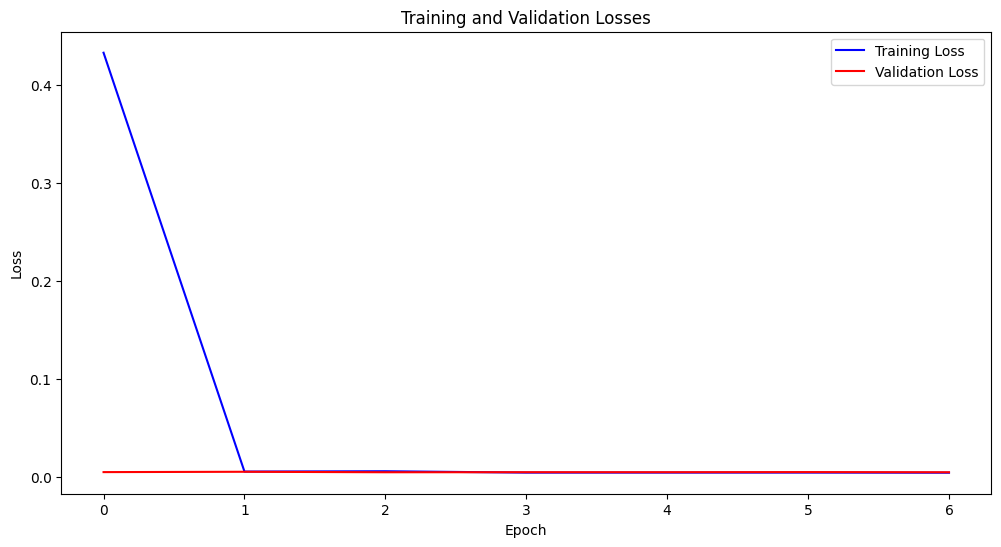

In [ ]:
train_epoch_losses, val_epoch_losses = train(positional_encoding_model, nn.MSELoss(), 7, 0.001, train_dataloader, val_dataloader)

plot_train_results(train_epoch_losses, val_epoch_losses)

Sigmoid Threshold: 0.0 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid Threshold: 0.05 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid Threshold: 0.1 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid Threshold: 0.15000000000000002 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid Threshold: 0.2 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid Threshold: 0.25 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid Threshold: 0.30000000000000004 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid Threshold: 0.35000000000000003 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid Threshold: 0.4 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid Threshold: 0.45 Precision: 0.3364693980778958 Recall: 1.0 F1 Score: 0.5035197941109681
Sigmoid T

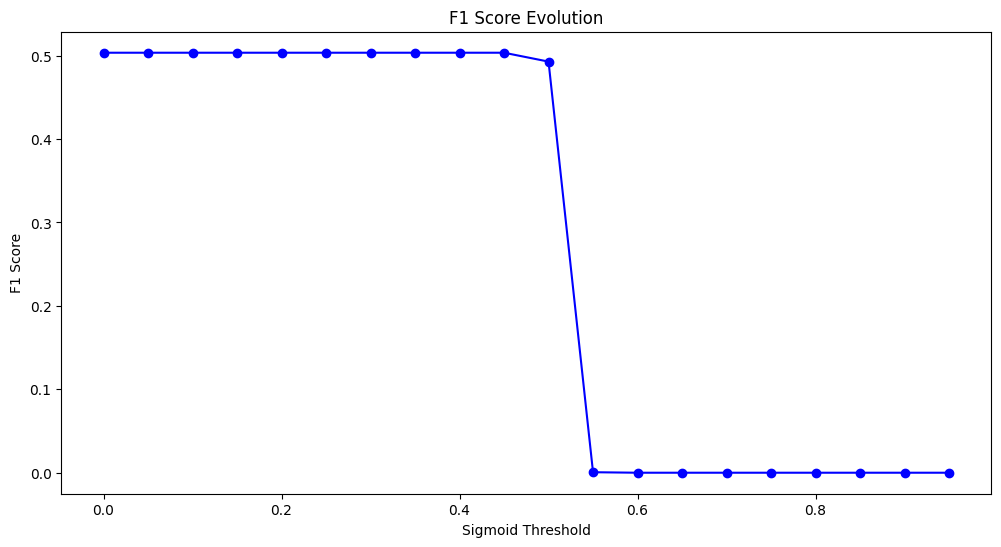

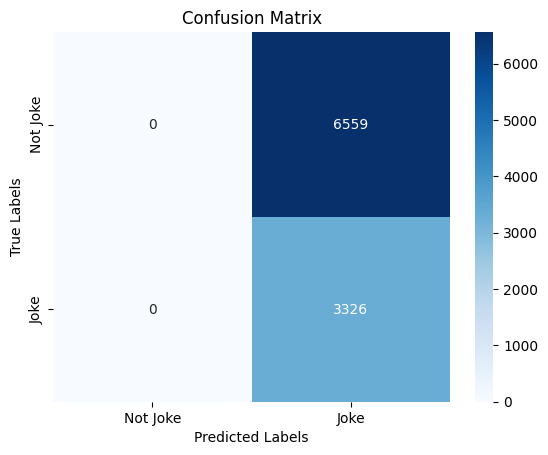

Precision: 0.3364693980778958
Recall: 1.0
F1 Score: 0.5035197941109681


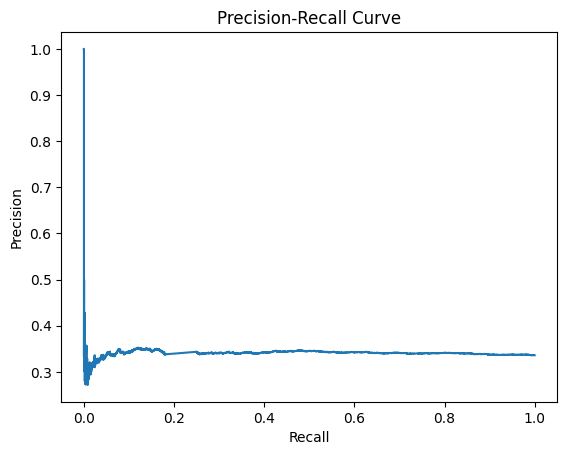

In [ ]:
best_sigmoid_threshold = find_best_sigmoid_threshold(positional_encoding_model, val_dataloader)

val_predictions, val_labels, val_scores = evaluate_model(positional_encoding_model, val_dataloader, best_sigmoid_threshold)

precision, recall, f1_score = plot_best_sigmoid_threshold_results(val_predictions, val_labels, val_scores)

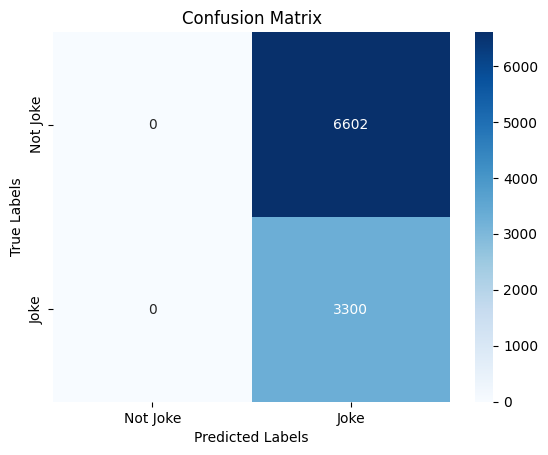

Precision: 0.3332660068672995
Recall: 1.0
F1 Score: 0.4999242539009241


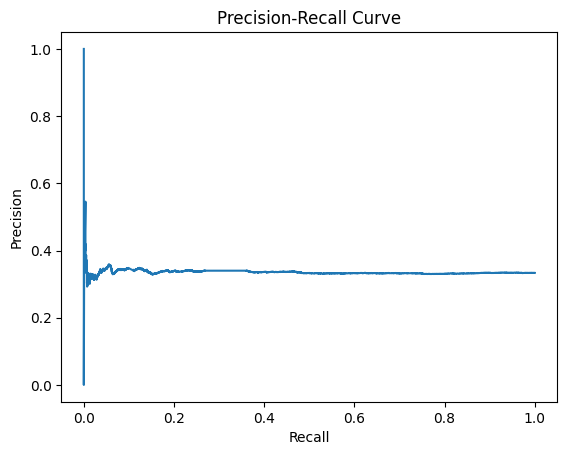

In [ ]:
test_predictions, test_labels, test_scores = evaluate_model(positional_encoding_model, test_dataloader, best_sigmoid_threshold)

precision, recall, f1_score = plot_best_sigmoid_threshold_results(test_predictions, test_labels, test_scores)